# Diabetes Patients Early Readmissions Prediction

**Authors:** [Peter Macinec](https://github.com/pmacinec), [Frantisek Sefcik](https://github.com/FrantisekSefcik)

## Model Selection

In this jupyter notebook, we will try multiple models for prediction and choose the best fitting one.

### Setup and import libraries

In [1]:
# Automatically reloading imported modules
%load_ext autoreload
%autoreload 2

In [2]:
import sys
sys.path.append('..')

# Supress libraries deprecation import warnings
import warnings
warnings.filterwarnings('ignore')

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
from sklearn.neural_network import MLPClassifier


from src.preprocessing.helpers import describe_dataset
from src.evaluation import *

### Load train and test data

In [4]:
X_train = pd.read_csv('../data/X_train.csv')
X_test = pd.read_csv('../data/X_test.csv')
y_train = pd.read_csv('../data/y_train.csv')
y_test = pd.read_csv('../data/y_test.csv')

In [5]:
describe_dataset(X_train, X_test, y_train, y_test)

Number of train data: 81409
Number of test data: 20353
Number of features: 58
Classes:
	0 :
	    train: 72315 samples, 89.0%
	    test: 18090 samples, 89.0%

	1 :
	    train: 9094 samples, 11.0%
	    test: 2263 samples, 11.0%



### Data balancing

#### Undersampling with NearMiss

In [6]:
X_train_undersampled, y_train_undersampled = undersample(X_train, y_train)

In [30]:
X_test_undersampled, y_test_undersampled = undersample(X_test, y_test)

In [7]:
len(X_train_undersampled), len(y_train_undersampled)

(18188, 18188)

#### Oversampling with SMOTE

In [8]:
X_train_oversampled, y_train_oversampled = oversample(X_train, y_train)

In [9]:
len(X_train_oversampled), len(y_train_oversampled)

(144630, 144630)

### Models training and evaluation

We will evaluate three models:
* Random forest
* MLP
* XGBoost

To final evaluation will be choosen a model with highest accuracy.

#### Random Forest

##### 1. Original data

              precision    recall  f1-score   support

           0       0.92      0.68      0.78     18090
           1       0.17      0.53      0.26      2263

    accuracy                           0.67     20353
   macro avg       0.55      0.61      0.52     20353
weighted avg       0.84      0.67      0.73     20353

ROC AUC score: 0.61


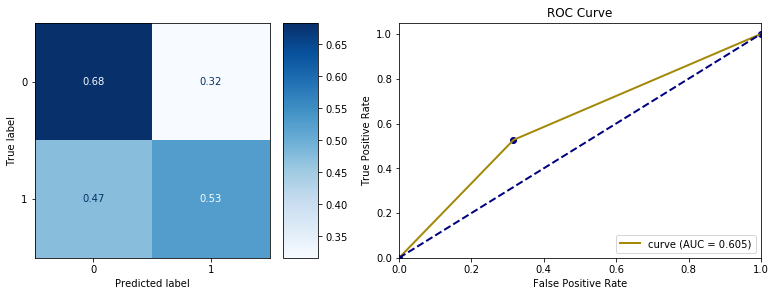

In [50]:
rf = RandomForestClassifier(max_depth=10, random_state=42, n_estimators=100
                             ,class_weight={0:1,1:8}, min_samples_split=5
                            )
rf.fit(X_train, y_train)
evaluate_model(rf, X_test, y_test)

##### 2. Undersampled data

              precision    recall  f1-score   support

           0       0.87      0.37      0.52     18090
           1       0.10      0.57      0.17      2263

    accuracy                           0.39     20353
   macro avg       0.49      0.47      0.35     20353
weighted avg       0.79      0.39      0.48     20353

ROC AUC score: 0.47


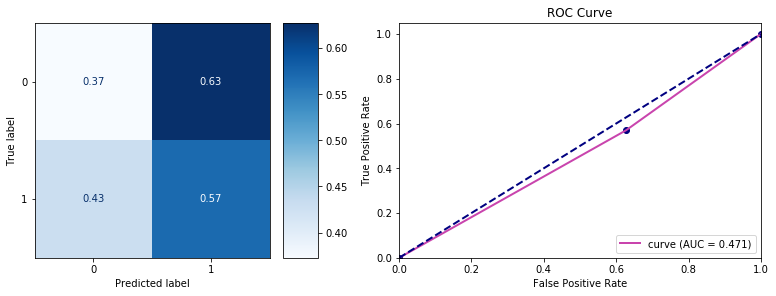

In [97]:
rf_u = RandomForestClassifier(max_depth=20, random_state=42, n_estimators=100, 
                             min_samples_leaf=2)
rf_u.fit(X_train_undersampled, y_train_undersampled)
evaluate_model(rf_u, X_test, y_test)

##### 3. Oversampled data

              precision    recall  f1-score   support

           0       0.89      0.99      0.94     18090
           1       0.22      0.02      0.03      2263

    accuracy                           0.88     20353
   macro avg       0.55      0.51      0.49     20353
weighted avg       0.82      0.88      0.84     20353

ROC AUC score: 0.51


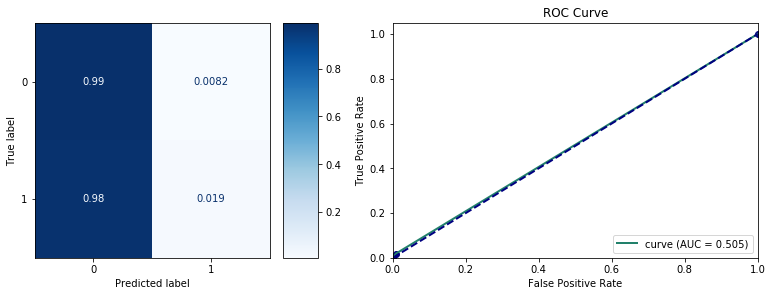

In [110]:
rf_o = RandomForestClassifier(max_depth=11, random_state=42, n_estimators=100, min_samples_leaf=2)
rf_o.fit(X_train_oversampled, y_train_oversampled)
evaluate_model(rf_o, X_test, y_test)

##### RF conclusion

In [111]:
compare_models([rf, rf_u, rf_o], 
               ['RF', 'RF undersampled', 'RF oversampled'], 
               X_test, y_test)

                    Accuracy   F1 (micro)  F1 (macro)  Precission   Recall   AUC ROC
RF                |   0.67   |   0.67    |   0.52    |   0.17    |   0.53   |   0.61   |
RF undersampled   |   0.39   |   0.39    |   0.35    |   0.10    |   0.57   |   0.47   |
RF oversampled    |   0.88   |   0.88    |   0.49    |   0.22    |   0.02   |   0.51   |


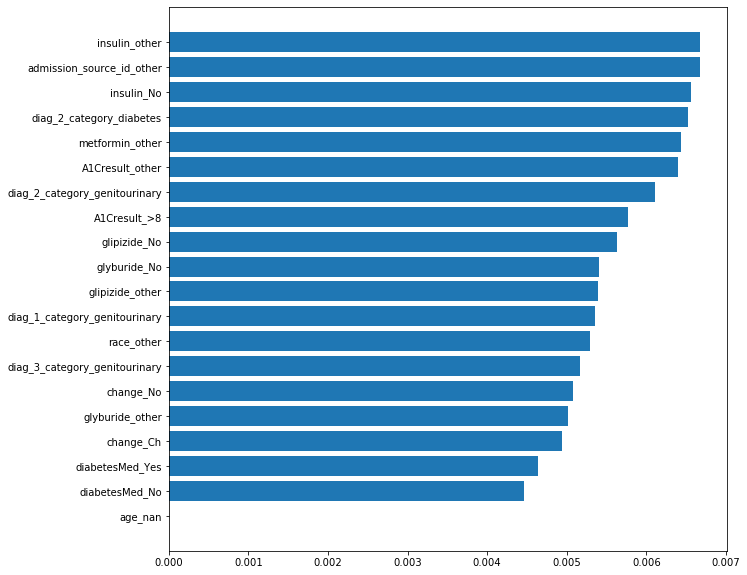

In [112]:
importances = rf.feature_importances_

sorted_features = plot_feature_importance(rf.feature_importances_, X_train.columns, 20)

#### XGBoost

##### 1. Original data

              precision    recall  f1-score   support

           0       0.89      0.99      0.94     18090
           1       0.27      0.02      0.03      2263

    accuracy                           0.89     20353
   macro avg       0.58      0.51      0.49     20353
weighted avg       0.82      0.89      0.84     20353

ROC AUC score: 0.51


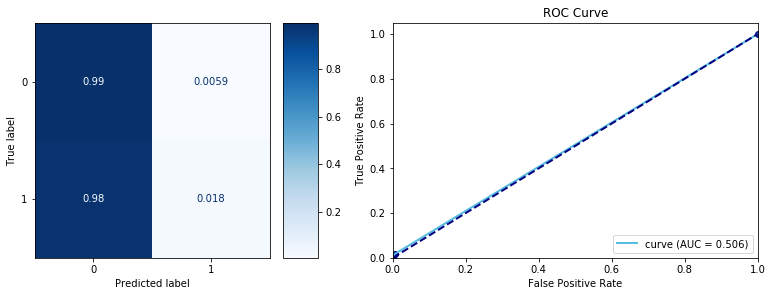

In [122]:
xg = xgb.XGBClassifier(random_state=42,learning_rate=0.01, max_depth=20, eta=0.1)
xg.fit(X_train,y_train)
evaluate_model(xg, X_test, y_test)

##### 2. Undersampled data

              precision    recall  f1-score   support

           0       0.86      0.36      0.51     18090
           1       0.10      0.55      0.17      2263

    accuracy                           0.38     20353
   macro avg       0.48      0.46      0.34     20353
weighted avg       0.78      0.38      0.47     20353

ROC AUC score: 0.46


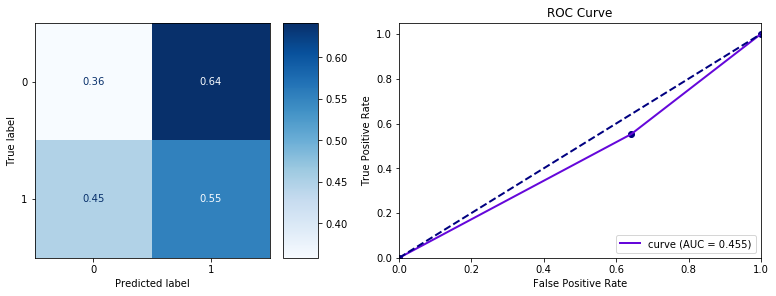

In [123]:
xg_u = xgb.XGBClassifier(random_state=42,learning_rate=0.01)
xg_u.fit(X_train_undersampled, y_train_undersampled)
evaluate_model(xg_u, X_test, y_test)

##### 3. Oversampled data

              precision    recall  f1-score   support

           0       0.89      0.97      0.93     18090
           1       0.15      0.05      0.07      2263

    accuracy                           0.86     20353
   macro avg       0.52      0.51      0.50     20353
weighted avg       0.81      0.86      0.83     20353

ROC AUC score: 0.51


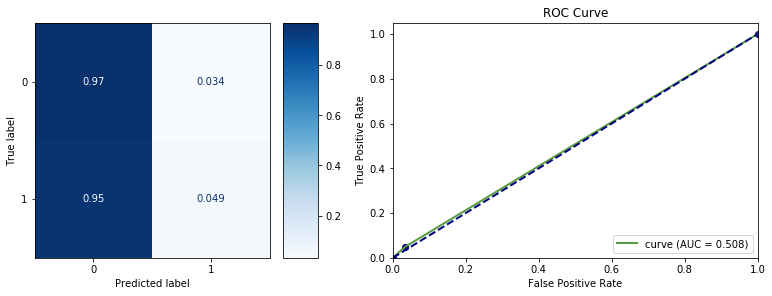

In [124]:
xg_o = xgb.XGBClassifier(random_state=42,learning_rate=0.01)
xg_o.fit(X_train_oversampled, y_train_oversampled)
evaluate_model(xg_o, X_test, y_test)

##### XGBoost conclusion

In [126]:
compare_models([xg, xg_u, xg_o], 
               ['XGBoost', 'XGBoost undersampled', 'XGBoost oversampled'], 
               X_test, y_test)

                         Accuracy   F1 (micro)  F1 (macro)  Precission   Recall   AUC ROC
XGBoost                |   0.89   |   0.89    |   0.49    |   0.27    |   0.02   |   0.51   |
XGBoost undersampled   |   0.38   |   0.38    |   0.34    |   0.10    |   0.55   |   0.46   |
XGBoost oversampled    |   0.86   |   0.86    |   0.50    |   0.15    |   0.05   |   0.51   |


#### MLP

##### 1. Original data

              precision    recall  f1-score   support

           0       0.89      1.00      0.94     18090
           1       0.40      0.01      0.02      2263

    accuracy                           0.89     20353
   macro avg       0.64      0.50      0.48     20353
weighted avg       0.84      0.89      0.84     20353

ROC AUC score: 0.5


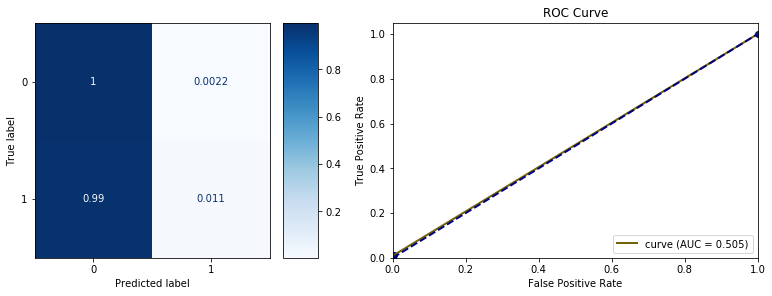

In [142]:
mlp = MLPClassifier(hidden_layer_sizes=(250,), max_iter=20, activation = 'relu',solver='adam')
mlp.fit(X_train, y_train)
evaluate_model(mlp, X_test, y_test)

##### 2. Undersampled data

              precision    recall  f1-score   support

           0       0.88      0.39      0.54     18090
           1       0.10      0.56      0.17      2263

    accuracy                           0.41     20353
   macro avg       0.49      0.48      0.36     20353
weighted avg       0.79      0.41      0.50     20353

ROC AUC score: 0.48


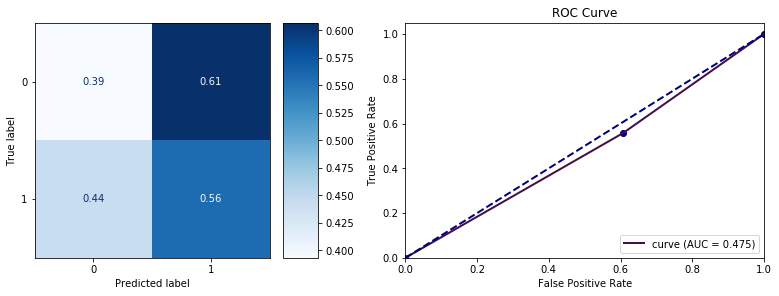

In [128]:
mlp_u = MLPClassifier(hidden_layer_sizes=(200,2), max_iter=20,activation = 'relu',solver='adam',random_state=1)
mlp_u.fit(X_train_undersampled, y_train_undersampled)
evaluate_model(mlp_u, X_test, y_test)

##### 3. Oversampled data

              precision    recall  f1-score   support

           0       0.89      1.00      0.94     18090
           1       0.44      0.00      0.01      2263

    accuracy                           0.89     20353
   macro avg       0.67      0.50      0.47     20353
weighted avg       0.84      0.89      0.84     20353

ROC AUC score: 0.5


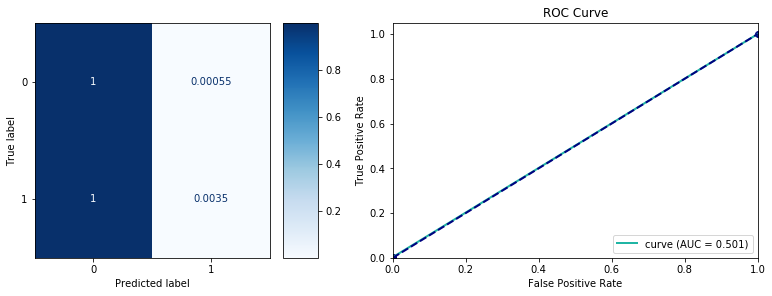

In [129]:
mlp_o = MLPClassifier(hidden_layer_sizes=(200,2), max_iter=20,activation = 'relu',solver='adam',random_state=1)
mlp_o.fit(X_train_oversampled, y_train_oversampled)
evaluate_model(mlp_o, X_test, y_test)

##### MLP conclusion

In [143]:
compare_models([mlp, mlp_u, mlp_o], 
               ['MLP', 'MLP undersampled', 'MLP oversampled'], 
               X_test, y_test)

                     Accuracy   F1 (micro)  F1 (macro)  Precission   Recall   AUC ROC
MLP                |   0.89   |   0.89    |   0.48    |   0.40    |   0.01   |   0.50   |
MLP undersampled   |   0.41   |   0.41    |   0.36    |   0.10    |   0.56   |   0.48   |
MLP oversampled    |   0.89   |   0.89    |   0.47    |   0.44    |   0.00   |   0.50   |


### Finall comparision of models

In [144]:
compare_models([rf, rf_u, rf_o, xg, xg_u, xg_o, mlp, mlp_u, mlp_o], 
               ['RF', 'RF undersampled', 'RF oversampled',
                'XGBoost', 'XGBoost undersampled', 'XGBoost oversampled',
                'MLP', 'MLP undersampled', 'MLP oversampled'], 
               X_test, y_test)

                         Accuracy   F1 (micro)  F1 (macro)  Precission   Recall   AUC ROC
RF                     |   0.67   |   0.67    |   0.52    |   0.17    |   0.53   |   0.61   |
RF undersampled        |   0.39   |   0.39    |   0.35    |   0.10    |   0.57   |   0.47   |
RF oversampled         |   0.88   |   0.88    |   0.49    |   0.22    |   0.02   |   0.51   |
XGBoost                |   0.89   |   0.89    |   0.49    |   0.27    |   0.02   |   0.51   |
XGBoost undersampled   |   0.38   |   0.38    |   0.34    |   0.10    |   0.55   |   0.46   |
XGBoost oversampled    |   0.86   |   0.86    |   0.50    |   0.15    |   0.05   |   0.51   |
MLP                    |   0.89   |   0.89    |   0.48    |   0.40    |   0.01   |   0.50   |
MLP undersampled       |   0.41   |   0.41    |   0.36    |   0.10    |   0.56   |   0.48   |
MLP oversampled        |   0.89   |   0.89    |   0.47    |   0.44    |   0.00   |   0.50   |
